In [243]:
libraries = c("dplyr", "magrittr", "tidyr", "gridExtra", "ggplot2", "readxl", "cmdstanr", "kableExtra", "IRdisplay",
              "posterior", "bayesplot", "lubridate", "glue")  
for(x in libraries) { suppressMessages(library(x, character.only=TRUE, warn.conflicts=FALSE, quietly=TRUE)) }

# the cmdpath should be changed if necessary 
set_cmdstan_path('../../../../CmdStan') %>% suppressMessages
# Sys.setlocale("LC_TIME", "C")
'%&%' = function(x,y)paste0(x,y)

R.Version()$version.string

[1] "R version 4.1.1 (2021-08-10)"

In [244]:
generateFigures = TRUE

In [245]:
truncation_date_data = as.Date("2021-08-25")
truncation_date = truncation_date_data#as.Date("2021-06-01")

backup_dir = "../../../Taiwan_Backup"
if (!dir.exists(backup_dir)) dir.create(backup_dir)

stanmaindir = paste0(backup_dir,"/202106-Reff_Wanhua_",format(truncation_date_data, "%Y%m%d"))
if (!dir.exists(stanmaindir)) dir.create(stanmaindir)

figures_main_dir = paste0("../../figures_",format(truncation_date_data, "%Y%m%d"))
if (!dir.exists(figures_main_dir)) dir.create(figures_main_dir)

figures_dir = paste0("../../figures_",format(truncation_date_data, "%Y%m%d"),"/draft")
if (!dir.exists(figures_dir)) dir.create(figures_dir)

results_dir = paste0("../../results_",format(truncation_date_data, "%Y%m%d"))
if (!dir.exists(results_dir)) dir.create(results_dir)

# Data

In [246]:
mindate = as.Date("2021-04-01")
(truncation_day = as.numeric(truncation_date - mindate))

[1] 146

In [ ]:
df = read.csv(file=format(truncation_date_data, "%Y%m%d")%&%"-data.csv") |>
    mutate(across(c("Onset", "OnsetL", "OnsetR", "SevereL", "SevereR", "HospitalizationL",
                    "Death", "DeathReport", "Report", "Confirm"), ~as.Date(., "%Y-%m-%d")),
           DeathDay = as.numeric(Death - mindate),
           DeathReportDay = as.numeric(DeathReport - mindate),
           OnsetDay = as.numeric(Onset - mindate),
           OnsetLDay = as.numeric(OnsetL - mindate),
           OnsetRDay = as.numeric(OnsetR - mindate),
           SevereLDay = as.numeric(SevereL - mindate),
           SevereRDay = as.numeric(SevereR - mindate),
           HospitalizationDay = as.numeric(HospitalizationL - mindate),
           ConfirmDay = as.numeric(Confirm - mindate)) |> 
    filter(Confirm <= truncation_date)

In [ ]:
# Lethal cases
df %>% filter(!is.na(Death), DeathReport <= truncation_date, !grepl('因其他原因死亡', Remarks, fixed = TRUE)) |> 
    select(ID, Age, Gender, contains("Onset"), contains("Report"), contains("Severe"), contains("Death"), contains("Hospitalization")) |>
    filter(DeathReport <= truncation_date) -> df_deaths

In [252]:
# double-checking 
df_deaths |> filter(OnsetR>Death)

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


ID,Age,Gender,Onset,OnsetDay,OnsetL,OnsetR,OnsetLDay,OnsetRDay,Report,⋯,DeathReportDay,SevereL,SevereR,SevereLDay,SevereRDay,Death,DeathDay,HospitalizationL,HospitalizationR,HospitalizationDay
<chr>,<int>,<chr>,<date>,<dbl>,<date>,<date>,<dbl>,<dbl>,<date>,⋯,<dbl>,<date>,<date>,<dbl>,<dbl>,<date>,<dbl>,<date>,<chr>,<dbl>


In [253]:
df_deaths |> filter(DeathReport<Death)

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


ID,Age,Gender,Onset,OnsetDay,OnsetL,OnsetR,OnsetLDay,OnsetRDay,Report,⋯,DeathReportDay,SevereL,SevereR,SevereLDay,SevereRDay,Death,DeathDay,HospitalizationL,HospitalizationR,HospitalizationDay
<chr>,<int>,<chr>,<date>,<dbl>,<date>,<date>,<dbl>,<dbl>,<date>,⋯,<dbl>,<date>,<date>,<dbl>,<dbl>,<date>,<dbl>,<date>,<chr>,<dbl>


In [254]:
df |> filter(SevereR<OnsetL)

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


ID,SevereL,SevereR,Onset,Report,Confirm,Gender,Age,ResidArea,ResidCounty,⋯,ResidCounty_eng,Age_group,OnsetL,OnsetR,Asymptomatic,OnsetLDay,OnsetRDay,SevereLDay,SevereRDay,HospitalizationDay
<chr>,<date>,<date>,<date>,<date>,<date>,<chr>,<int>,<chr>,<chr>,⋯,<chr>,<int>,<date>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


# <font color="brown">Time intervals </font>

## <font color="purple">A0. From illness onset to case confirmation</font>

In [ ]:
# only positive delays are observed, so no shift to negative values has been incorporated
standirname = stanmaindir%&%"/"%&%format(truncation_date,"%Y%m%d")%&%"_onset2confirm"
#unlink(standirname, recursive=T)
dir.create(standirname)

stan_code = 'data {
    int<lower=0> N_total; // number of records
    int<lower=0> N; // number of records with positive reporting delay
    array[N] int onset, // illness onset in day number
                 confirm; // death in day number

    int<lower = max(confirm)> truncation_day;
    
    /* for generated quantities = to plot the PDF */
    int M; // number of points
    real xmin; // left boundary for the plot
    real<lower = xmin> xmax; // right boundary for the plot
}

transformed data {
    int D = 3; // number of distributions (Gamma, Weibull, Lognormal)

    array[N] int delay_obs;
    for (n in 1:N)
        delay_obs[n] = confirm[n] - onset[n];
}

parameters {
    vector<lower=-1, upper=1>[N] delay_raw; 

    real<lower=0> mu; // mean 
    real<lower=0> param1_weibull;

    real<lower = 0, upper = 1> theta; // probability of reporting the case on the same day as their onset or earlier
    
    simplex[D] weight; // mixing proportions
}

transformed parameters {
    real<lower = 0> sigma; // SD 

    vector[D] param1, param2;

    vector[D] lps = log(weight); // internal component likelihoods 
    // we use hurdle model for fitting the reporting delay 
    // https://mc-stan.org/docs/2_20/stan-users-guide/zero-inflated-section.html
    lps += (N_total - N)*log(theta) + N*log1m(theta);
    {
        // Weibull distribution
        param1[2] = param1_weibull;
        param2[2] = mu / tgamma(1.0 + 1.0 / param1[2]); 
        sigma = param2[2] * sqrt(tgamma(1.0 + 2.0 / param1[2]) - square(tgamma(1.0 + 1.0 / param1[2])));

        // Gamma distribution
        param1[1] = square(mu / sigma);
        param2[1] = mu / square(sigma);

        // Lognormal distribution
        param2[3] = sqrt(log(square(sigma / mu) + 1.0));
        param1[3] = log(mu) - square(param2[3]) / 2.0;
        
        // component likelihoods
        lps[1] += gamma_lpdf(to_vector(delay_obs) + delay_raw | param1[1], param2[1]) 
                - gamma_lcdf(truncation_day - to_vector(onset) + 0.5 | param1[1], param2[1]);
        lps[2] += weibull_lpdf(to_vector(delay_obs) + delay_raw | param1[2], param2[2]) 
                - weibull_lcdf(truncation_day - to_vector(onset) + 0.5 | param1[2], param2[2]);
        lps[3] += lognormal_lpdf(to_vector(delay_obs) + delay_raw | param1[3], param2[3]) 
                - lognormal_lcdf(truncation_day - to_vector(onset) + 0.5 | param1[3], param2[3]);
    }
}

model {
    /* priors */
    mu ~ normal(5, 5);
    param1_weibull ~ exponential(0.001);

    delay_raw ~ uniform(-1, 1);

    target += log_sum_exp(lps);
}

generated quantities {  
    vector<lower = 0, upper = 1>[D] q = exp(lps - log_sum_exp(lps));
    int comp = categorical_rng(q);
    real delay;

    if (comp == 2) 
        delay = (bernoulli_rng(theta)) ? 0 : weibull_rng(param1[comp], param2[comp]);
    else if (comp == 1) 
        delay = (bernoulli_rng(theta)) ? 0 : gamma_rng(param1[comp], param2[comp]);
    else if (comp == 3) 
        delay = (bernoulli_rng(theta)) ? 0 : lognormal_rng(param1[comp], param2[comp]);
}' %>% cat(file=standirname %&% "/model.stan", sep="", fill=TRUE)

ERROR: Error in stanmaindir %&% "/" %&% format(truncation_date, "%Y%m%d") %&% : could not find function "%&%"


In [ ]:
recalc_delay = F
df_delay = df %>% filter(!is.na(Onset)) %>% mutate(Delay = ConfirmDay - OnsetDay) %>% arrange(-Delay)
df_delay_ = df_delay %>% filter(Delay>0)
if (recalc_delay) {
    foo = \() {
        N_total = nrow(df_delay)
        N = nrow(df_delay_)
        onset = df_delay_$OnsetDay
        confirm = df_delay_$ConfirmDay
        M = 240
        xmin = 0
        xmax = 24
        truncation_day = truncation_day 
        rstan::stan_rdump(c("N_total", "N", "onset", "confirm", "truncation_day", 
                            "M", "xmin", "xmax"), file=standirname%&%"/Data.R") }; foo()
    foo = \() {
        delay_raw = rep(.3, nrow(df_delay_))
        mu = 5.0
        param1_weibull = 3.2
        rstan::stan_rdump(c("delay_raw", "mu", "param1_weibull"), file=standirname%&%"/Init.R") }; foo()

    standistribdir = "../../../../CmdStan"
    stanscriptdir = "../Dropbox/" %&% substring(standirname,10)

    ## bash file
    "#!/bin/bash
    cwd=$(pwd)
    cd "%&%standistribdir%&%"
    make -j4 "%&%stanscriptdir%&%"/model
    cd "%&%stanscriptdir%&%"
    mkdir -p diagnostics
    for i in {1..4}
    do
        echo Running ${i}
        SEEDNUMBER=$((1+$i))
        ./model \\
            method=sample num_samples=2500 num_warmup=4000 save_warmup=0 \\
                algorithm=hmc \\
                    engine=nuts \\
            random seed=${SEEDNUMBER} \\
            id=$i \\
            data file=Data.R \\
            init=Init.R \\
            output file=trace-$i.csv \\
                diagnostic_file=diagnostics/diagnostics-$i.csv > diagnostics/output-$i.txt &
    done
    echo Finished sampling haha!
    " %>% cat(file=standirname%&%"/fit.sh", sep="", fill=TRUE)

    ## running the bash script
    system("bash "%&%standirname%&%"/fit.sh", intern = TRUE)
};

ERROR: Error in df %>% filter(!is.na(Onset)) %>% mutate(Delay = ConfirmDay - : could not find function "%>%"


In [257]:
output_files = c()
for (fl_ in list.files(standirname, "*.csv", full.names = TRUE)[-5])
    if (grepl("trace-", fl_, fixed = TRUE))
        output_files = c(output_files, fl_)
(output_files)
mod_onset2confirm = as_cmdstan_fit(output_files, check_diagnostics=T)

[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_onset2confirm/trace-1.csv"
[2] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_onset2confirm/trace-2.csv"
[3] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_onset2confirm/trace-3.csv"
[4] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_onset2confirm/trace-4.csv"

Joining, by = "variable"



variable,estimate,IQR,mean,sd
<chr>,<chr>,<chr>,<dbl>,<dbl>
mu,"3.9 (95% CI: 3.9, 4.0)",3.9-3.9,3.927359e+00,0.03338991
sigma,"3.1 (95% CI: 3.0, 3.2)",3.1-3.1,3.107311e+00,0.05122485
delay,"3.0 (95% CI: 0.7, 11.9)",1.9-4.9,3.877586e+00,3.01054829
q[1],"0.0 (95% CI: 0.0, 0.0)",0.0-0.0,2.570470e-296,0.00000000
q[2],"0.0 (95% CI: 0.0, 0.0)",0.0-0.0,0.000000e+00,0.00000000
q[3],"1.0 (95% CI: 1.0, 1.0)",1.0-1.0,1.000000e+00,0.00000000


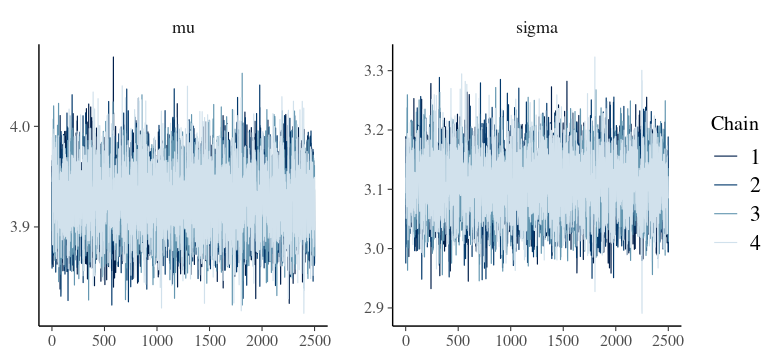

In [258]:
mod_onset2confirm$summary(c("mu", "sigma", "delay", "q"), 
    ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame -> df_fit_summary

names(df_fit_summary) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
mod_onset2confirm$summary(c("mu", "sigma", "delay", "q")) %>% select(variable, mean, sd) %>% left_join(df_fit_summary) -> df_fit_summary
df_fit_summary %<>% 
    mutate(
        estimate = sprintf("%.1f (95%% CI: %.1f, %.1f)", median, lower, upper),
        IQR = sprintf("%.1f-%.1f", IQR_lower, IQR_upper)
        ) %>% select(variable, estimate, IQR, mean, sd)

df_fit_summary 

options(repr.plot.width=6.5, repr.plot.height=3)
mcmc_trace(mod_onset2confirm$draws(c("mu","sigma"))) 

## <font color="purple">A. From illness onset to severe symptoms</font>

In [259]:
# only positive delays are observed, so no shift to negative values has been incorporated
standirname = stanmaindir%&%"/"%&%format(truncation_date,"%Y%m%d")%&%"_onset2severe"
#unlink(standirname, recursive=T)
dir.create(standirname)

stan_code = 'data {
    int<lower=0> N; // number of records 
    array[N] int onsetL, onsetR, // illness onset in day number
                 severeL, severeR; 

    int<lower = max(severeR)+1> truncation_day;
}

transformed data {
    int D = 3; // number of distributions (Gamma, Weibull, Lognormal)
}

parameters {
    vector<lower=0, upper=1>[N] onset_raw, severe_raw; 

    real<lower=0> mu; // mean 
    real<lower=0> param1_weibull;
    
    simplex[D] weight; // mixing proportions
}

transformed parameters {
    real<lower = 0> sigma; // SD 
    vector[D] param1, param2;

    vector[D] lps = log(weight); // internal component likelihoods 
    {
        vector[N] onset, severe, delay;
        onset = fma(to_vector(onsetR) + 1 - to_vector(onsetL), onset_raw, to_vector(onsetL));
        for (i in 1:N) 
            severe[i] = (severeL[i] > onset[i]) ? 
                                fma(severeR[i] + 1 - severeL[i], severe_raw[i], severeL[i]) :
                                fma(severeR[i] + 1 - onset[i], severe_raw[i], onset[i]);
        delay = severe - onset;

        // Weibull distribution
        param1[2] = param1_weibull;
        param2[2] = mu / tgamma(1.0 + 1.0 / param1[2]); 
        sigma = param2[2] * sqrt(tgamma(1.0 + 2.0 / param1[2]) - square(tgamma(1.0 + 1.0 / param1[2])));

        // Gamma distribution
        param1[1] = square(mu / sigma);
        param2[1] = mu / square(sigma);

        // Lognormal distribution
        param2[3] = sqrt(log(square(sigma / mu) + 1.0));
        param1[3] = log(mu) - square(param2[3]) / 2.0;
        
        // component likelihoods
        lps[1] += gamma_lpdf(delay | param1[1], param2[1]) - gamma_lcdf(truncation_day - onset + 0.583 | param1[1], param2[1]);
        lps[2] += weibull_lpdf(delay | param1[2], param2[2]) - weibull_lcdf(truncation_day - onset + 0.583 | param1[2], param2[2]);
        lps[3] += lognormal_lpdf(delay | param1[3], param2[3]) - lognormal_lcdf(truncation_day - onset + 0.583 | param1[3], param2[3]);
    }
}

model {
    /* priors */
    mu ~ normal(14, 14);
    param1_weibull ~ exponential(0.001);

    onset_raw ~ beta(1, 1);
    severe_raw ~ beta(1, 1);

    target += log_sum_exp(lps);
}

generated quantities {  
    vector<lower = 0, upper = 1>[D] q = exp(lps - log_sum_exp(lps));
    int comp = categorical_rng(q);
    real delay;

    if (comp == 2)
        delay = weibull_rng(param1[comp], param2[comp]);
    else if (comp == 1)
        delay = gamma_rng(param1[comp], param2[comp]);
    else if (comp == 3)
        delay = lognormal_rng(param1[comp], param2[comp]);
}' %>% cat(file=standirname %&% "/model.stan", sep="", fill=TRUE)

Warning message in dir.create(standirname):
“'../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_onset2severe' already exists”


In [261]:
recalc_delay = F
df_ = df |> filter(!is.na(OnsetL), !is.na(OnsetR), !is.na(SevereL), !is.na(SevereR)) |> 
    mutate(SevereL = ifelse(OnsetL > SevereL, OnsetL, SevereL)) 
if (recalc_delay) {
    foo = \() {
        N = nrow(df_)
        onsetL = df_$OnsetLDay
        onsetR = df_$OnsetRDay
        severeL = df_$SevereLDay
        severeR = df_$SevereRDay
        truncation_day = truncation_day 
        rstan::stan_rdump(c("N", "onsetL", "onsetR", "severeL", "severeR", "truncation_day"), 
                          file=standirname%&%"/Data.R") }; foo()
    foo = \() {
        onset_raw = rep(.05, nrow(df_))
        severe_raw = rep(.95, nrow(df_))
        mu = 4.0
        param1_weibull = 3.2
        rstan::stan_rdump(c("onset_raw", "severe_raw", "mu", "param1_weibull"), file=standirname%&%"/Init.R") }; foo()

    standistribdir = "../../../../CmdStan"
    stanscriptdir = "../Dropbox/" %&% substring(standirname,10)

    ## bash file
    "#!/bin/bash
    cwd=$(pwd)
    cd "%&%standistribdir%&%"
    make -j4 "%&%stanscriptdir%&%"/model
    cd "%&%stanscriptdir%&%"
    mkdir -p diagnostics
    for i in {1..4}
    do
        echo Running ${i}
        SEEDNUMBER=$((1+$i))
        ./model \\
            method=sample num_samples=2500 num_warmup=4000 save_warmup=0 \\
                algorithm=hmc \\
                    engine=nuts \\
            random seed=${SEEDNUMBER} \\
            id=$i \\
            data file=Data.R \\
            init=Init.R \\
            output file=trace-$i.csv \\
                diagnostic_file=diagnostics/diagnostics-$i.csv > diagnostics/output-$i.txt &
    done
    echo Finished sampling haha!
    " %>% cat(file=standirname%&%"/fit.sh", sep="", fill=TRUE)

    ## running the bash script
    system("bash "%&%standirname%&%"/fit.sh", intern = TRUE)
};

In [262]:
output_files = c()
for (fl_ in list.files(standirname, "*.csv", full.names = TRUE)[-5])
    if (grepl("trace-", fl_, fixed = TRUE))
        output_files = c(output_files, fl_)
(output_files)
mod_onset2severe = as_cmdstan_fit(output_files, check_diagnostics=FALSE)

[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_onset2severe/trace-1.csv"
[2] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_onset2severe/trace-2.csv"
[3] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_onset2severe/trace-3.csv"
[4] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_onset2severe/trace-4.csv"

Joining, by = "variable"



variable,estimate,IQR,mean,sd
<chr>,<chr>,<chr>,<dbl>,<dbl>
mu,"9.6 (95% CI: 9.4, 9.9)",9.5-9.7,9.609845e+00,1.355447e-01
sigma,"7.8 (95% CI: 7.4, 8.3)",7.7-8.0,7.842500e+00,2.336738e-01
delay,"7.5 (95% CI: 1.8, 30.5)",4.6-12.3,9.752714e+00,8.033915e+00
q[1],"0.0 (95% CI: 0.0, 0.0)",0.0-0.0,1.090363e-65,1.090360e-63
q[2],"0.0 (95% CI: 0.0, 0.0)",0.0-0.0,1.685944e-111,1.191987e-109
q[3],"1.0 (95% CI: 1.0, 1.0)",1.0-1.0,1.000000e+00,0.000000e+00


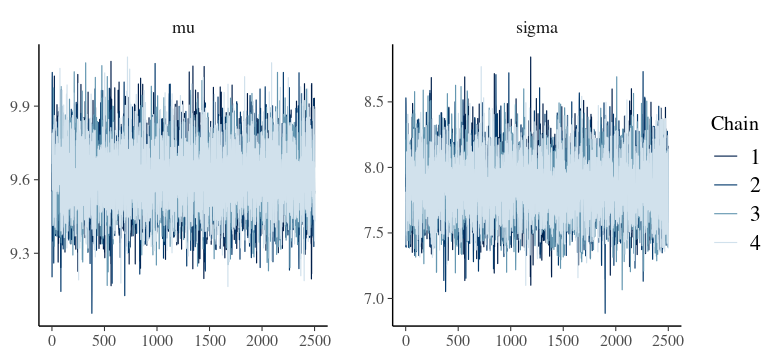

In [263]:
mod_onset2severe$summary(c("mu", "sigma", "delay", "q"), 
    ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame -> df_fit_summary

names(df_fit_summary) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
mod_onset2severe$summary(c("mu", "sigma", "delay", "q")) %>% select(variable, mean, sd) %>% left_join(df_fit_summary) -> df_fit_summary
df_fit_summary %<>% 
    mutate(
        estimate = sprintf("%.1f (95%% CI: %.1f, %.1f)", median, lower, upper),
        IQR = sprintf("%.1f-%.1f", IQR_lower, IQR_upper)
        ) %>% select(variable, estimate, IQR, mean, sd)

df_fit_summary 

options(repr.plot.width=6.5, repr.plot.height=3)
mcmc_trace(mod_onset2severe$draws(c("mu","sigma"))) 

## <font color="purple">B. From illness onset to death</font>

In [264]:
standirname = stanmaindir%&%"/"%&%format(truncation_date,"%Y%m%d")%&%"_onset2death"
#unlink(standirname, recursive=T)
dir.create(standirname)

stan_code = 'data {
    int<lower=0> N; // number of records
    array[N] int onsetL, onsetR, // illness onset in day number
                 deathL, deathR; // death in day number

    int<lower = max(deathR)> truncation_day;
}

transformed data {
    int D = 3; // number of distributions (Gamma, Weibull, Lognormal)
}

parameters {
    vector<lower=0, upper=1>[N] onset_raw, death_raw; 

    real<lower=0> mu; // mean 
    real<lower=0> param1_weibull;
    
    simplex[D] weight; // mixing proportions
}

transformed parameters {
    real<lower = 0> sigma; // SD 

    vector[D] param1;
    vector[D] param2;

    vector[D] lps = log(weight); // internal component likelihoods 
    {
        vector[N] onset, death, delay;
        onset = fma(to_vector(onsetR) + 1 - to_vector(onsetL), onset_raw, to_vector(onsetL));
        for (i in 1:N) 
            death[i] = (deathL[i] > onset[i]) ? 
                                fma(deathR[i] + 1 - deathL[i], death_raw[i], deathL[i]) :
                                fma(deathR[i] + 1 - onset[i], death_raw[i], onset[i]);
        delay = death - onset;

        // Weibull distribution
        param1[2] = param1_weibull;
        param2[2] = mu / tgamma(1.0 + 1.0 / param1[2]); 
        sigma = param2[2] * sqrt(tgamma(1.0 + 2.0 / param1[2]) - square(tgamma(1.0 + 1.0 / param1[2])));

        // Gamma distribution
        param1[1] = square(mu / sigma);
        param2[1] = mu / square(sigma);

        // Lognormal distribution
        param2[3] = sqrt(log(square(sigma / mu) + 1.0));
        param1[3] = log(mu) - square(param2[3]) / 2.0;
        
        // component likelihoods
        lps[1] += gamma_lpdf(delay | param1[1], param2[1]) - gamma_lcdf(truncation_day - onset + 0.583 | param1[1], param2[1]);
        lps[2] += weibull_lpdf(delay | param1[2], param2[2]) - weibull_lcdf(truncation_day - onset + 0.583 | param1[2], param2[2]);
        lps[3] += lognormal_lpdf(delay | param1[3], param2[3]) - lognormal_lcdf(truncation_day - onset + 0.583 | param1[3], param2[3]);
    }
}

model {
    /* priors */
    mu ~ normal(14, 14);
    param1_weibull ~ exponential(0.001);

    onset_raw ~ beta(1, 1);
    death_raw ~ beta(1, 1);

    target += log_sum_exp(lps);
}

generated quantities {  
    vector<lower = 0, upper = 1>[D] q = exp(lps - log_sum_exp(lps));
    int comp = categorical_rng(q);
    real delay;

    if (comp == 2) 
        delay = weibull_rng(param1[comp], param2[comp]);
    else if (comp == 1)
        delay = gamma_rng(param1[comp], param2[comp]);
    else if (comp == 3)
        delay = lognormal_rng(param1[comp], param2[comp]);
}' %>% cat(file=standirname %&% "/model.stan", sep="", fill=TRUE)

Warning message in dir.create(standirname):
“'../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_onset2death' already exists”


In [265]:
df_ = df_deaths |> filter(!is.na(OnsetL), !is.na(DeathDay))
recalc_delay = F
if (recalc_delay) {
    foo = \() {
        N = nrow(df_)
        onsetL = df_$OnsetLDay
        onsetR = df_$OnsetRDay
        deathL = df_$DeathDay
        deathR = df_$DeathDay
        truncation_day = truncation_day 
        rstan::stan_rdump(c("N", "onsetL", "onsetR", "deathL", "deathR", "truncation_day"), 
                          file=standirname%&%"/Data.R") }; foo()
    foo = \() {
        onset_raw = rep(.3, nrow(df_))
        death_raw = rep(.7, nrow(df_))
        mu = 21.0
        param1_weibull = 2.5
        rstan::stan_rdump(c("onset_raw", "death_raw", "mu", "param1_weibull"), file=standirname%&%"/Init.R") }; foo()

    standistribdir = "../../../../CmdStan"
    stanscriptdir = "../Dropbox/" %&% substring(standirname,10)

    ## bash file
    "#!/bin/bash
    cwd=$(pwd)
    cd "%&%standistribdir%&%"
    make -j6 "%&%stanscriptdir%&%"/model
    cd "%&%stanscriptdir%&%"
    mkdir -p diagnostics
    for i in {1..4}
    do
        echo Running ${i}
        SEEDNUMBER=$((1+$i))
        ./model \\
            method=sample num_samples=2500 num_warmup=4000 save_warmup=0 \\
                algorithm=hmc \\
                    engine=nuts \\
            random seed=${SEEDNUMBER} \\
            id=$i \\
            data file=Data.R \\
            init=Init.R \\
            output file=trace-$i.csv \\
                diagnostic_file=diagnostics/diagnostics-$i.csv > diagnostics/output-$i.txt &
    done
    echo Finished sampling haha!
    " %>% cat(file=standirname%&%"/fit.sh", sep="", fill=TRUE)

    ## running the bash script
    system("bash "%&%standirname%&%"/fit.sh", intern = TRUE)
};

In [266]:
output_files = c()
for (fl_ in list.files(standirname, "*.csv", full.names = TRUE)[-3])
    if (grepl("trace-", fl_, fixed = TRUE))
        output_files = c(output_files, fl_)
(output_files)
mod_onset2death = as_cmdstan_fit(output_files, check_diagnostics=FALSE)

[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_onset2death/trace-1.csv"
[2] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_onset2death/trace-2.csv"
[3] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_onset2death/trace-4.csv"

Joining, by = "variable"



variable,estimate,IQR,mean,sd
<chr>,<chr>,<chr>,<dbl>,<dbl>
mu,"17.3 (95% CI: 16.4, 18.4)",17.0-17.7,1.735642e+01,5.215844e-01
sigma,"14.4 (95% CI: 13.3, 15.7)",14.0-14.8,1.441331e+01,6.258717e-01
delay,"13.3 (95% CI: 0.8, 53.0)",6.5-24.2,1.716135e+01,1.415636e+01
q[1],"0.0 (95% CI: 0.0, 0.1)",0.0-0.0,8.117664e-03,4.938171e-02
q[2],"1.0 (95% CI: 0.9, 1.0)",1.0-1.0,9.918823e-01,4.938171e-02
q[3],"0.0 (95% CI: 0.0, 0.0)",0.0-0.0,4.550281e-108,3.940658e-106


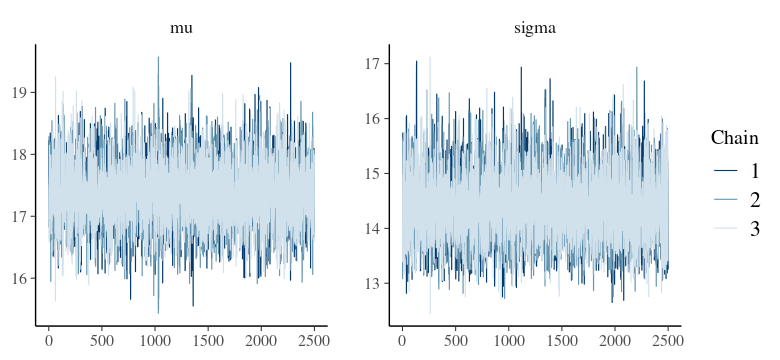

In [267]:
mod_onset2death$summary(c("mu", "sigma", "delay", "q"), 
    ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame -> df_fit_summary

names(df_fit_summary) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
mod_onset2death$summary(c("mu", "sigma", "delay", "q")) %>% select(variable, mean, sd) %>% left_join(df_fit_summary) -> df_fit_summary
df_fit_summary %<>% 
    mutate(
        estimate = sprintf("%.1f (95%% CI: %.1f, %.1f)", median, lower, upper),
        IQR = sprintf("%.1f-%.1f", IQR_lower, IQR_upper)
        ) %>% select(variable, estimate, IQR, mean, sd)

df_fit_summary 

options(repr.plot.width=6.5, repr.plot.height=3)
mcmc_trace(mod_onset2death$draws(c("mu","sigma"))) 

## <font color="purple">C. From illness death to death report</font>

In [268]:
standirname = stanmaindir%&%"/"%&%format(truncation_date,"%Y%m%d")%&%"_death2deathReport"
#unlink(standirname, recursive=T)
dir.create(standirname)

stan_code = 'data {
    int<lower=0> N; // number of records
    array[N] int deathL, deathR, // illness onset in day number
                 deathReportL, deathReportR; // death in day number

    int<lower = max(deathR)> truncation_day;
}

transformed data {
    int D = 3; // number of distributions (Gamma, Weibull, Lognormal)
}

parameters {
    vector<lower=0, upper=1>[N] death_raw, deathReport_raw; 

    real<lower=0> mu; // mean 
    real<lower=0> param1_weibull;
    
    simplex[D] weight; // mixing proportions
}

transformed parameters {
    real<lower = 0> sigma; // SD 

    vector[D] param1, param2;

    vector[D] lps = log(weight); // internal component likelihoods 
    {
        vector[N] death, deathReport, delay;
        death = fma(to_vector(deathR) + 1 - to_vector(deathL), death_raw, to_vector(deathL));
        for (i in 1:N) 
            deathReport[i] = (deathReportL[i] > death[i]) ? 
                                fma(deathReportR[i] + 1 - deathReportL[i], deathReport_raw[i], deathReportL[i]) :
                                fma(deathReportR[i] + 1 - death[i], deathReport_raw[i], death[i]);
        delay = deathReport - death;

        // Weibull distribution
        param1[2] = param1_weibull;
        param2[2] = mu / tgamma(1.0 + 1.0 / param1[2]); 
        sigma = param2[2] * sqrt(tgamma(1.0 + 2.0 / param1[2]) - square(tgamma(1.0 + 1.0 / param1[2])));

        // Gamma distribution
        param1[1] = square(mu / sigma);
        param2[1] = mu / square(sigma);

        // Lognormal distribution
        param2[3] = sqrt(log(square(sigma / mu) + 1.0));
        param1[3] = log(mu) - square(param2[3]) / 2.0;
        
        // component likelihoods
        lps[1] += gamma_lpdf(delay | param1[1], param2[1]) - gamma_lcdf(truncation_day - death + 0.583 | param1[1], param2[1]);
        lps[2] += weibull_lpdf(delay | param1[2], param2[2]) - weibull_lcdf(truncation_day - death + 0.583 | param1[2], param2[2]);
        lps[3] += lognormal_lpdf(delay | param1[3], param2[3]) - lognormal_lcdf(truncation_day - death + 0.583 | param1[3], param2[3]);
    }
}

model {
    /* priors */
    mu ~ normal(14, 14);
    param1_weibull ~ exponential(0.001);

    death_raw ~ beta(1, 1);
    death_raw ~ beta(1, 1);

    target += log_sum_exp(lps);
}

generated quantities {  
    vector<lower = 0, upper = 1>[D] q = exp(lps - log_sum_exp(lps));
    int comp = categorical_rng(q);
    real delay;

    if (comp == 2)
        delay = weibull_rng(param1[comp], param2[comp]);
    else if (comp == 1)
        delay = gamma_rng(param1[comp], param2[comp]);
    else if (comp == 3)
        delay = lognormal_rng(param1[comp], param2[comp]);
}' %>% cat(file=standirname %&% "/model.stan", sep="", fill=TRUE)

Warning message in dir.create(standirname):
“'../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_death2deathReport' already exists”


In [269]:
df_ = df_deaths |> filter(!is.na(Death), !is.na(DeathReport))
df_ |> filter(DeathReport < Death)

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


ID,Age,Gender,Onset,OnsetDay,OnsetL,OnsetR,OnsetLDay,OnsetRDay,Report,⋯,DeathReportDay,SevereL,SevereR,SevereLDay,SevereRDay,Death,DeathDay,HospitalizationL,HospitalizationR,HospitalizationDay
<chr>,<int>,<chr>,<date>,<dbl>,<date>,<date>,<dbl>,<dbl>,<date>,⋯,<dbl>,<date>,<date>,<dbl>,<dbl>,<date>,<dbl>,<date>,<chr>,<dbl>


In [270]:
recalc_delay = F
if (recalc_delay) {
    foo = \() {
        N = nrow(df_)
        deathL = df_$DeathDay
        deathR = df_$DeathDay
        deathReportL = df_$DeathReportDay
        deathReportR = df_$DeathReportDay
        truncation_day = truncation_day 
        rstan::stan_rdump(c("N", "deathL", "deathR", "deathReportL", "deathReportR", 
                            "truncation_day"), 
                          file=standirname%&%"/Data.R") }; foo()
    foo = \() {
        death_raw = rep(.3, nrow(df_))
        deathReport_raw = rep(.7, nrow(df_))
        mu = 21.0
        param1_weibull = 2.5
        rstan::stan_rdump(c("death_raw", "deathReport_raw", "mu", "param1_weibull"), file=standirname%&%"/Init.R") }; foo()

    standistribdir = "../../../../CmdStan"
    stanscriptdir = "../Dropbox/" %&% substring(standirname,10)

    ## bash file
    "#!/bin/bash
    cwd=$(pwd)
    cd "%&%standistribdir%&%"
    make -j6 "%&%stanscriptdir%&%"/model
    cd "%&%stanscriptdir%&%"
    mkdir -p diagnostics
    for i in {1..4}
    do
        echo Running ${i}
        SEEDNUMBER=$((1+$i))
        ./model \\
            method=sample num_samples=2500 num_warmup=4000 save_warmup=0 \\
                algorithm=hmc \\
                    engine=nuts \\
            random seed=${SEEDNUMBER} \\
            id=$i \\
            data file=Data.R \\
            init=Init.R \\
            output file=trace-$i.csv \\
                diagnostic_file=diagnostics/diagnostics-$i.csv > diagnostics/output-$i.txt &
    done
    echo Finished sampling haha!
    " %>% cat(file=standirname%&%"/fit.sh", sep="", fill=TRUE)

    ## running the bash script
    system("bash "%&%standirname%&%"/fit.sh", intern = TRUE)
};

In [271]:
output_files = c()
for (fl_ in list.files(standirname, "*.csv", full.names = TRUE))
    if (grepl("trace-", fl_, fixed = TRUE))
        output_files = c(output_files, fl_)
(output_files)
mod_death2deathReport = as_cmdstan_fit(output_files, check_diagnostics=FALSE)

[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_death2deathReport/trace-1.csv"
[2] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_death2deathReport/trace-2.csv"
[3] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_death2deathReport/trace-3.csv"
[4] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_death2deathReport/trace-4.csv"

Joining, by = "variable"



variable,estimate,IQR,mean,sd
<chr>,<chr>,<chr>,<dbl>,<dbl>
mu,"4.3 (95% CI: 4.1, 4.5)",4.2-4.4,4.283484e+00,1.072696e-01
sigma,"3.0 (95% CI: 2.7, 3.3)",2.9-3.1,2.980887e+00,1.442920e-01
delay,"3.6 (95% CI: 1.0, 12.5)",2.3-5.4,4.351822e+00,3.131702e+00
q[1],"0.0 (95% CI: 0.0, 0.0)",0.0-0.0,3.867881e-45,1.452787e-43
q[2],"0.0 (95% CI: 0.0, 0.0)",0.0-0.0,6.604892e-74,3.777628e-72
q[3],"1.0 (95% CI: 1.0, 1.0)",1.0-1.0,1.000000e+00,0.000000e+00


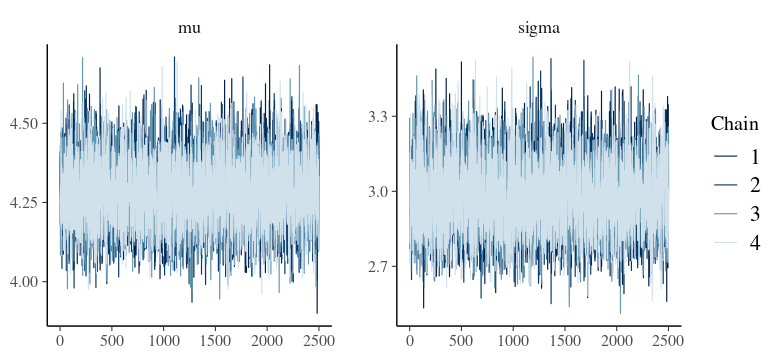

In [272]:
mod_death2deathReport$summary(c("mu", "sigma", "delay", "q"), 
    ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame -> df_fit_summary

names(df_fit_summary) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
mod_death2deathReport$summary(c("mu", "sigma", "delay", "q")) %>% select(variable, mean, sd) %>% left_join(df_fit_summary) -> df_fit_summary
df_fit_summary %<>% 
    mutate(
        estimate = sprintf("%.1f (95%% CI: %.1f, %.1f)", median, lower, upper),
        IQR = sprintf("%.1f-%.1f", IQR_lower, IQR_upper)
        ) %>% select(variable, estimate, IQR, mean, sd)

df_fit_summary 

options(repr.plot.width=6.5, repr.plot.height=3)
mcmc_trace(mod_death2deathReport$draws(c("mu","sigma"))) 

## <font color="purple">D. From illness onset to death report</font>

In [273]:
standirname = stanmaindir%&%"/"%&%format(truncation_date,"%Y%m%d")%&%"_onset2deathReport"
#unlink(standirname, recursive=T)
dir.create(standirname)

stan_code = 'data {
    int<lower=0> N; // number of records
    array[N] int onsetL, onsetR, // illness onset in day number
                 deathReportL, deathReportR; // death in day number

    int<lower = max(deathReportR)> truncation_day;
}

transformed data {
    int D = 3; // number of distributions (Gamma, Weibull, Lognormal)
}

parameters {
    vector<lower=0, upper=1>[N] onset_raw, deathReport_raw; 

    real<lower=0> mu; // mean 
    real<lower=0> param1_weibull;
    
    simplex[D] weight; // mixing proportions
}

transformed parameters {
    real<lower = 0> sigma; // SD 

    vector[D] param1;
    vector[D] param2;

    vector[D] lps = log(weight); // internal component likelihoods 
    {
        vector[N] onset, deathReport, delay;
        onset = fma(to_vector(onsetR) + 1 - to_vector(onsetL), onset_raw, to_vector(onsetL));
        for (i in 1:N) 
            deathReport[i] = (deathReportL[i] > onset[i]) ? 
                                fma(deathReportR[i] + 1 - deathReportL[i], deathReport_raw[i], deathReportL[i]) :
                                fma(deathReportR[i] + 1 - onset[i], deathReport_raw[i], onset[i]);
        delay = deathReport - onset;

        // Weibull distribution
        param1[2] = param1_weibull;
        param2[2] = mu / tgamma(1.0 + 1.0 / param1[2]); 
        sigma = param2[2] * sqrt(tgamma(1.0 + 2.0 / param1[2]) - square(tgamma(1.0 + 1.0 / param1[2])));

        // Gamma distribution
        param1[1] = square(mu / sigma);
        param2[1] = mu / square(sigma);

        // Lognormal distribution
        param2[3] = sqrt(log(square(sigma / mu) + 1.0));
        param1[3] = log(mu) - square(param2[3]) / 2.0;
        
        // component likelihoods
        lps[1] += gamma_lpdf(delay | param1[1], param2[1]) - gamma_lcdf(truncation_day - onset + 0.583 | param1[1], param2[1]);
        lps[2] += weibull_lpdf(delay | param1[2], param2[2]) - weibull_lcdf(truncation_day - onset + 0.583 | param1[2], param2[2]);
        lps[3] += lognormal_lpdf(delay | param1[3], param2[3]) - lognormal_lcdf(truncation_day - onset + 0.583 | param1[3], param2[3]);
    }
}

model {
    /* priors */
    mu ~ normal(14, 14);
    param1_weibull ~ exponential(0.001);

    onset_raw ~ beta(1, 1);
    deathReport_raw ~ beta(1, 1);

    target += log_sum_exp(lps);
}

generated quantities {  
    vector<lower = 0, upper = 1>[D] q = exp(lps - log_sum_exp(lps));
    int comp = categorical_rng(q);
    real delay;

    if (comp == 2)
        delay = weibull_rng(param1[comp], param2[comp]);
    else if (comp == 1)
        delay = gamma_rng(param1[comp], param2[comp]);
    else if (comp == 3)
        delay = lognormal_rng(param1[comp], param2[comp]);
}' %>% cat(file=standirname %&% "/model.stan", sep="", fill=TRUE)

Warning message in dir.create(standirname):
“'../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_onset2deathReport' already exists”


In [274]:
df_ = df_deaths |> filter(!is.na(OnsetL), !is.na(DeathReportDay))
recalc_delay = F
if (recalc_delay) {
    foo = \() {
        N = nrow(df_)
        onsetL = df_$OnsetLDay
        onsetR = df_$OnsetRDay
        deathReportL = df_$DeathReportDay
        deathReportR = df_$DeathReportDay
        truncation_day = truncation_day 
        rstan::stan_rdump(c("N", "onsetL", "onsetR", "deathReportL", "deathReportR", "truncation_day"), 
                          file=standirname%&%"/Data.R") }; foo()
    foo = \() {
        onset_raw = rep(.3, nrow(df_))
        deathReport_raw = rep(.7, nrow(df_))
        mu = 21.0
        param1_weibull = 2.5
        rstan::stan_rdump(c("onset_raw", "deathReport_raw", "mu", "param1_weibull"), file=standirname%&%"/Init.R") }; foo()

    standistribdir = "../../../../CmdStan"
    stanscriptdir = "../Dropbox/" %&% substring(standirname,10)

    ## bash file
    "#!/bin/bash
    cwd=$(pwd)
    cd "%&%standistribdir%&%"
    make -j4 "%&%stanscriptdir%&%"/model
    cd "%&%stanscriptdir%&%"
    mkdir -p diagnostics
    for i in {1..4}
    do
        echo Running ${i}
        SEEDNUMBER=$((1+$i))
        ./model \\
            method=sample num_samples=2500 num_warmup=4000 save_warmup=0 \\
                algorithm=hmc \\
                    engine=nuts \\
            random seed=${SEEDNUMBER} \\
            id=$i \\
            data file=Data.R \\
            init=Init.R \\
            output file=trace-$i.csv \\
                diagnostic_file=diagnostics/diagnostics-$i.csv > diagnostics/output-$i.txt &
    done
    echo Finished sampling haha!
    " %>% cat(file=standirname%&%"/fit.sh", sep="", fill=TRUE)

    ## running the bash script
    system("bash "%&%standirname%&%"/fit.sh", intern = TRUE)
};

In [275]:
output_files = c()
for (fl_ in list.files(standirname, "*.csv", full.names = TRUE))
    if (grepl("trace-", fl_, fixed = TRUE))
        output_files = c(output_files, fl_)
(output_files)
mod_onset2deathReport = as_cmdstan_fit(output_files, check_diagnostics=FALSE)

[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_onset2deathReport/trace-1.csv"
[2] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_onset2deathReport/trace-2.csv"
[3] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_onset2deathReport/trace-3.csv"
[4] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_onset2deathReport/trace-4.csv"

Joining, by = "variable"



variable,estimate,IQR,mean,sd
<chr>,<chr>,<chr>,<dbl>,<dbl>
mu,"22.8 (95% CI: 21.5, 24.4)",22.3-23.3,2.285061e+01,7.311090e-01
sigma,"18.2 (95% CI: 16.3, 20.7)",17.5-19.0,1.829562e+01,1.128160e+00
delay,"17.9 (95% CI: 4.4, 70.4)",11.2-28.8,2.287845e+01,1.810110e+01
q[1],"0.0 (95% CI: 0.0, 0.0)",0.0-0.0,1.365028e-09,1.277293e-07
q[2],"0.0 (95% CI: 0.0, 0.0)",0.0-0.0,4.596507e-20,2.233633e-18
q[3],"1.0 (95% CI: 1.0, 1.0)",1.0-1.0,1.000000e+00,1.300000e-07


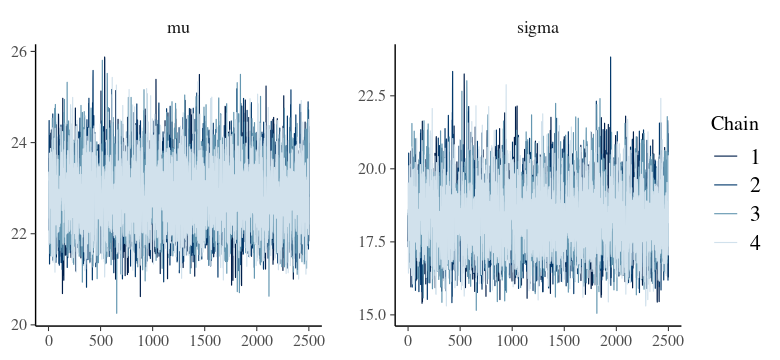

In [276]:
mod_onset2deathReport$summary(c("mu", "sigma", "delay", "q"), 
    ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame -> df_fit_summary

names(df_fit_summary) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
mod_onset2deathReport$summary(c("mu", "sigma", "delay", "q")) %>% select(variable, mean, sd) %>% left_join(df_fit_summary) -> df_fit_summary
df_fit_summary %<>% 
    mutate(
        estimate = sprintf("%.1f (95%% CI: %.1f, %.1f)", median, lower, upper),
        IQR = sprintf("%.1f-%.1f", IQR_lower, IQR_upper)
        ) %>% select(variable, estimate, IQR, mean, sd)

df_fit_summary 

options(repr.plot.width=6.5, repr.plot.height=3)
mcmc_trace(mod_onset2deathReport$draws(c("mu","sigma"))) 